# I. Predicting Fuel Consumption - Step by Step
### Exploration of the use of Machine Learning to predict fuel consumption.

For this analysis we use the Auto-mpg dataset found on the Kaggle Data Repository at the following location:

<a href=https://www.kaggle.com/uciml/autompg-dataset>Auto-mpg dataset</a>

"The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued
discrete and 5 continuous attributes." (Quinlan, 1993)

"This dataset is a slightly modified version of the dataset provided in the StatLib library. In line with the use by
Ross Quinlan (1993) in predicting the attribute "mpg", 8 of the original instances were removed because they had
unknown values for the "mpg" attribute. The original dataset is available in the file "auto-mpg.data-original".

The Data Dictionary for this dataset is as follows:

| Variable | Definition | Type |
|----------|------------|-----|
| mpg | Miles per Gallon | Continuous |
| cylinders | No. of Cylinders  | Discrete |
| displacement | Size of engine | Continuous |
| horsepower | Power output | Continuous |
| weight | Vehicle weight | Continuous |
| acceleration | Vehicle acceleration | Continuous |
| model_year | Vehicle model | Discrete |
| origin | Vehicle country of manufacture | Discrete |
| car_name | Vehicle make and model | Unique |

In this notebook we will do some high level analyses, implement ML pipelines for simple ML model comparison and
investigate the use of Response Curve otherwise known as Partial Dependency Plots for investigation of the
relationship between various features and the responses. The PDPs also indicate how well the model fits the data from
 the perspective of different features, and is hence useful from two different perspectives.

In [1]:
import pandas as pd
import pandas_profiling
import seaborn as sns
from matplotlib import style
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import itertools
import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-info">
<b>Load data</b>
</div>

In [2]:
df = pd.read_csv('../data/processed/auto-mpg.csv', delimiter = ",")


Let us have a look at the original data:

In [3]:
df.shape


(398, 9)

In [4]:
df.head()


mpg  cylinders  displacement horsepower  weight  acceleration  model year  \
0  18.0          8         307.0        130    3504          12.0          70   
1  15.0          8         350.0        165    3693          11.5          70   
2  18.0          8         318.0        150    3436          11.0          70   
3  16.0          8         304.0        150    3433          12.0          70   
4  17.0          8         302.0        140    3449          10.5          70   

   origin                   car name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino

In [5]:
df_auto = df.copy()

We start by renaming columns to align with our data dictionary and then we One Hot Encode categorical variables.

In [6]:
# Rename columns to align with our data dictionary.
df_auto = df_auto.rename(columns = {'model year': 'model_year', 'car name': 'car_name'})
df_auto_orig = df_auto.copy()

In [7]:
# Split car_name variable in make and model
df_auto['car_make'] = df_auto['car_name'].str.split(' ', 1).str.get(0)
df_auto['car_model'] = df_auto['car_name'].str.split(' ', 1).str.get(1)
#df_auto.head()

In [8]:
df_auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
 9   car_make      398 non-null    object 
 10  car_model     396 non-null    object 
dtypes: float64(3), int64(4), object(4)
memory usage: 34.3+ KB


Convert numeric variables to numeric data types.

In [9]:
#df_auto.loc[~df_auto['horsepower'].astype(str).str.isdigit()]
df_auto = df_auto.replace('?', np.nan)
#df_auto.loc[~df_auto['horsepower'].astype(str).str.isdigit()]
df_auto['horsepower'] = df_auto['horsepower'].astype(float)

In [10]:
categorical_cols = ['cylinders', 'model_year', 'origin']
quantitative_cols = ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']
# Re-order columns
col_names = ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration', 'cylinders', 'model_year', 'origin',
             'car_make', 'car_model']
df_auto = df_auto.loc[:, col_names]

In [11]:
#df_auto_model = pd.get_dummies(df_auto, columns = categorical_cols, drop_first=True)
#cols = list(df_auto_model.columns.values)

The dataset looks as follows now:

In [12]:
df_auto.sample(10, random_state=0)

mpg  displacement  horsepower  weight  acceleration  cylinders  \
65   14.0         351.0       153.0    4129          13.0          8   
132  25.0         140.0        75.0    2542          17.0          4   
74   13.0         302.0       140.0    4294          16.0          8   
78   21.0         120.0        87.0    2979          19.5          4   
37   18.0         232.0       100.0    3288          15.5          6   
54   35.0          72.0        69.0    1613          18.0          4   
294  34.1          86.0        65.0    1975          15.2          4   
60   20.0         140.0        90.0    2408          19.5          4   
12   15.0         400.0       150.0    3761           9.5          8   
341  23.5         173.0       110.0    2725          12.6          6   

     model_year  origin   car_make         car_model  
65           72       1       ford       galaxie 500  
132          74       1  chevrolet              vega  
74           72       1       ford  gran torino (sw)  
78           72       2    peugeot          504 (sw)  
37           71       1        amc           matador  
54           71       3     datsun              1200  
294          79       3      maxda        glc deluxe  
60           72       1  chevrolet              vega  
12           70       1  chevrolet       monte carlo  
341          81       1  chevrolet          citation

<div class="alert alert-block alert-info">
<b>Exploration of data</b>
</div>

For this analysis we start by exploring the automatic EDA functionality in Pandas.

The notebook by Sercan Yeşilöz pointed us in this direction:

<a href=https://www.kaggle.com/sercanyesiloz/vehicle-fuel-consumption-prediction-xgboost>Vehicle Fuel Consumption
Prediction (XGBoost)</a>



In [13]:
df_auto.profile_report()


Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Missing values

We quantify the exact number of missing values in the data set:

In [14]:
# Check for null values
missing_values_train = df_auto.isnull().sum()
missing_values_train = missing_values_train.to_frame(name='num_missing')
missing_values_train['perc_missing'] = (missing_values_train['num_missing']/df_auto.shape[0])*100
for index, row in missing_values_train.iterrows():
    if (row['num_missing'] > 0):
        print ("For \"%s\" the number of missing values are: %d (%.0f%%)" %  (index,
                                                                     row['num_missing'],
                                                                    row['perc_missing']))

For "horsepower" the number of missing values are: 6 (2%)
For "car_model" the number of missing values are: 2 (1%)


There are missing values in the car model only.

Now we analyse the distribution of continuous variables to get a feel for the data.


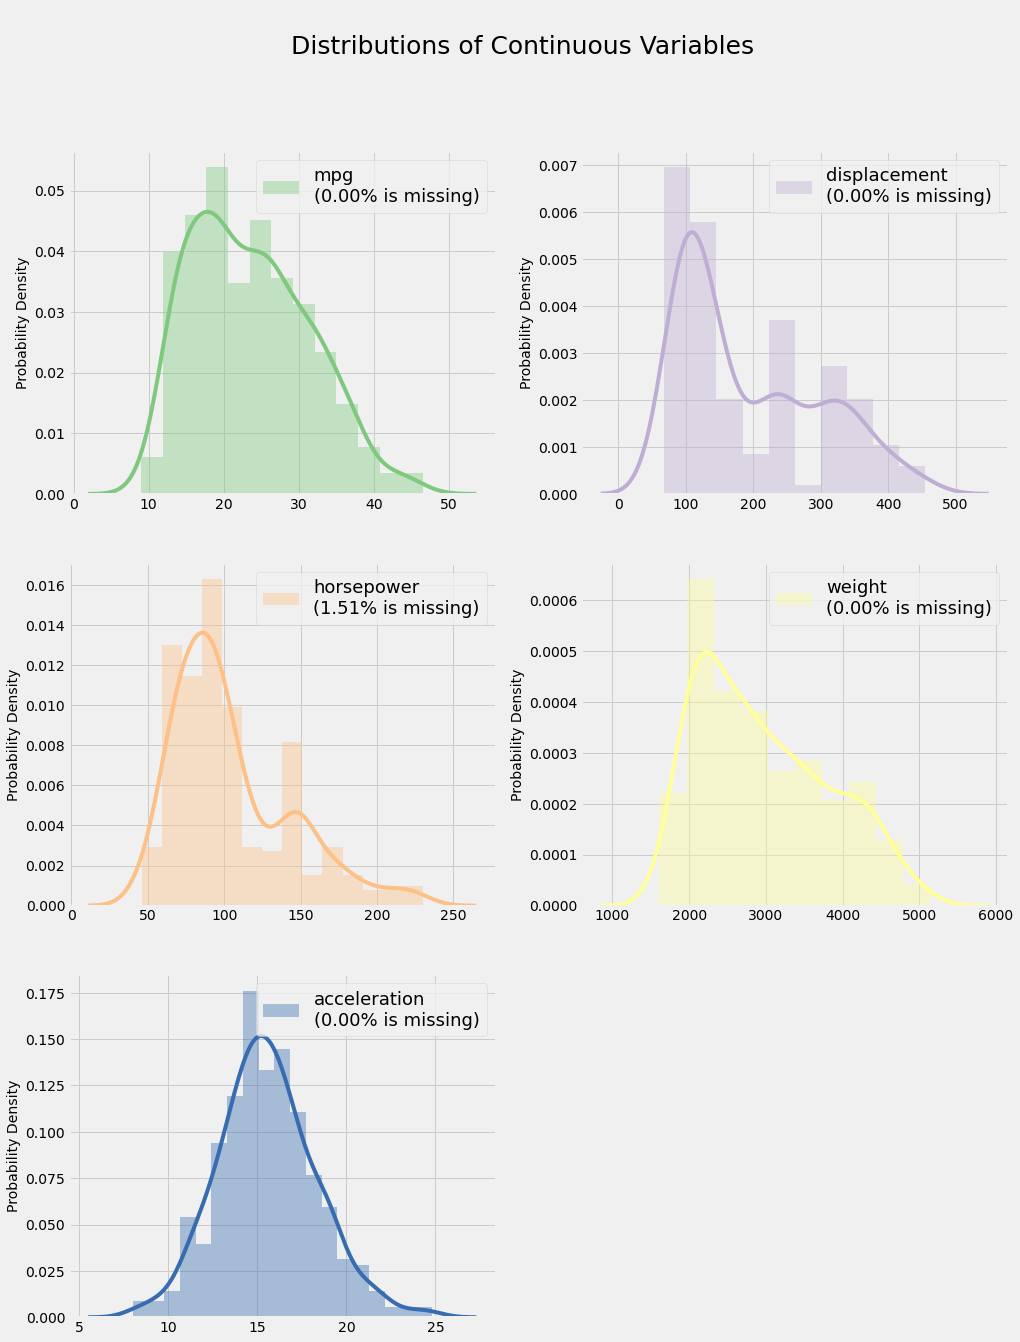

In [15]:
style.use('fivethirtyeight')
sns.set_palette('Accent')
palette = itertools.cycle(sns.color_palette('Accent'))

n_rows, n_cols = (3,2)

figure, axes = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(15, 20))
figure.suptitle('\nDistributions of Continuous Variables', fontsize=25)

for index, column in enumerate(quantitative_cols):
    i,j = (index // n_cols), (index % n_cols)
    miss_perc="%.2f"%(100*(1-(df_auto[column].dropna().shape[0])/df_auto.shape[0]))
    collabel=column+"\n({}% is missing)".format(miss_perc)
    fig=sns.distplot(df_auto[column], label=collabel, norm_hist=True,
    ax=axes[i,j], kde_kws={"lw":4}, color=next(palette))
    fig=fig.legend(loc='best', fontsize=18)
    axes[i,j].set_ylabel("Probability Density",fontsize='medium')
    axes[i,j].set_xlabel(None)
figure.delaxes(axes[2,1])

plt.show()

Data seems fairly reasonable, no outliers. We will continue with analysis for now, and do a more in-depth EDA in a
later notebook.

Next we consider the categorical variables.

We first look at the distribution of the response.

In [16]:
style.use('seaborn-darkgrid')

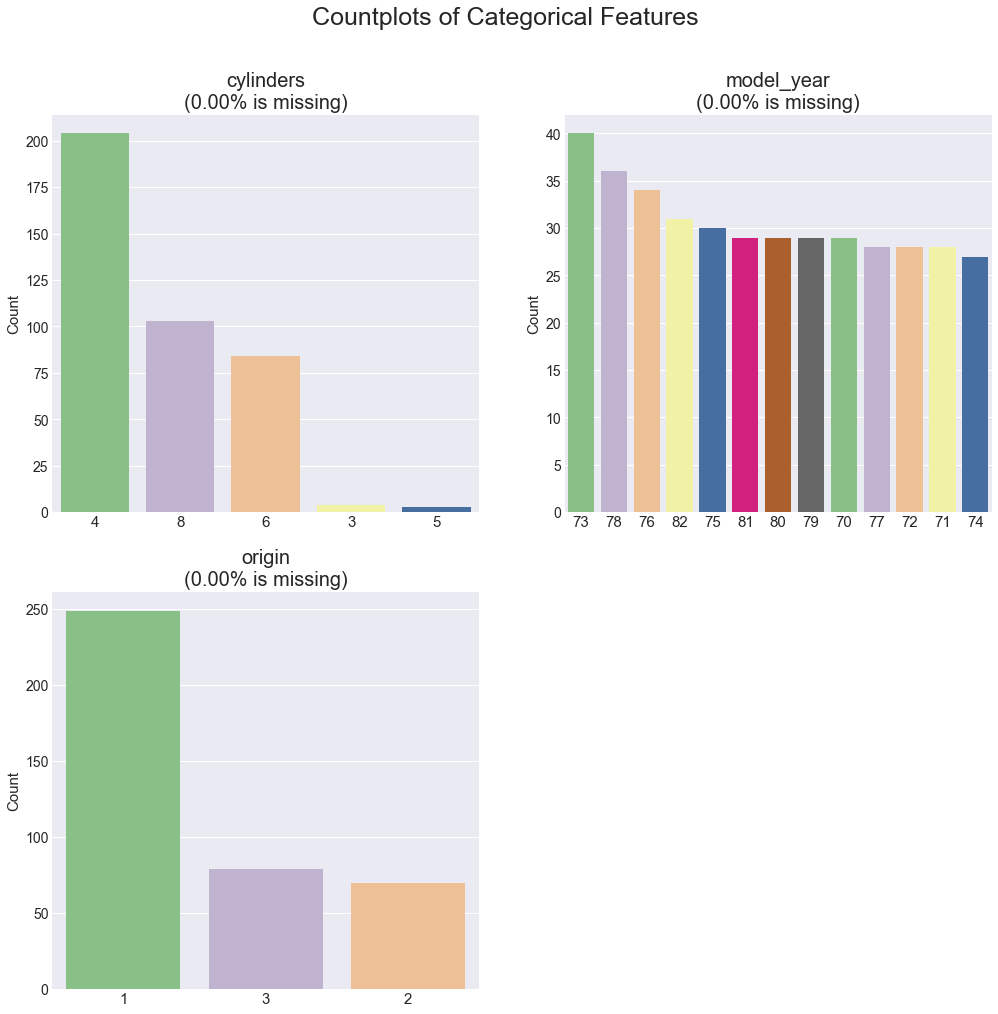

In [17]:
n_rows, n_cols = (2,2)

figure, axes = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(15, 15))
figure.suptitle('Countplots of Categorical Features', fontsize=25)

for index, column in enumerate(categorical_cols):
    i,j = index // n_cols, index % n_cols
    miss_perc="%.2f"%(100*(1-(df_auto[column].dropna().shape[0])/df_auto.shape[0]))
    collabel=column+"\n({}% is missing)".format(miss_perc)
    fig = sns.countplot(x=column, data=df_auto,label=collabel, palette='Accent',
    ax=axes[i,j], order = df_auto[column].value_counts().index)
    axes[i,j].set_title(collabel,fontsize=20)
    axes[i,j].set_xlabel(None)
    axes[i,j].set_ylabel("Count",fontsize=15)
    axes[i,j].set_xticklabels(axes[i,j].get_xticklabels(), Fontsize=15)
figure.delaxes(axes[1,1])

plt.show()

There is good variation in all the categorical variables. We will perform a more in depth analysis later.

We now look at pairwise relationships between variables.

<Figure size 432x288 with 0 Axes>

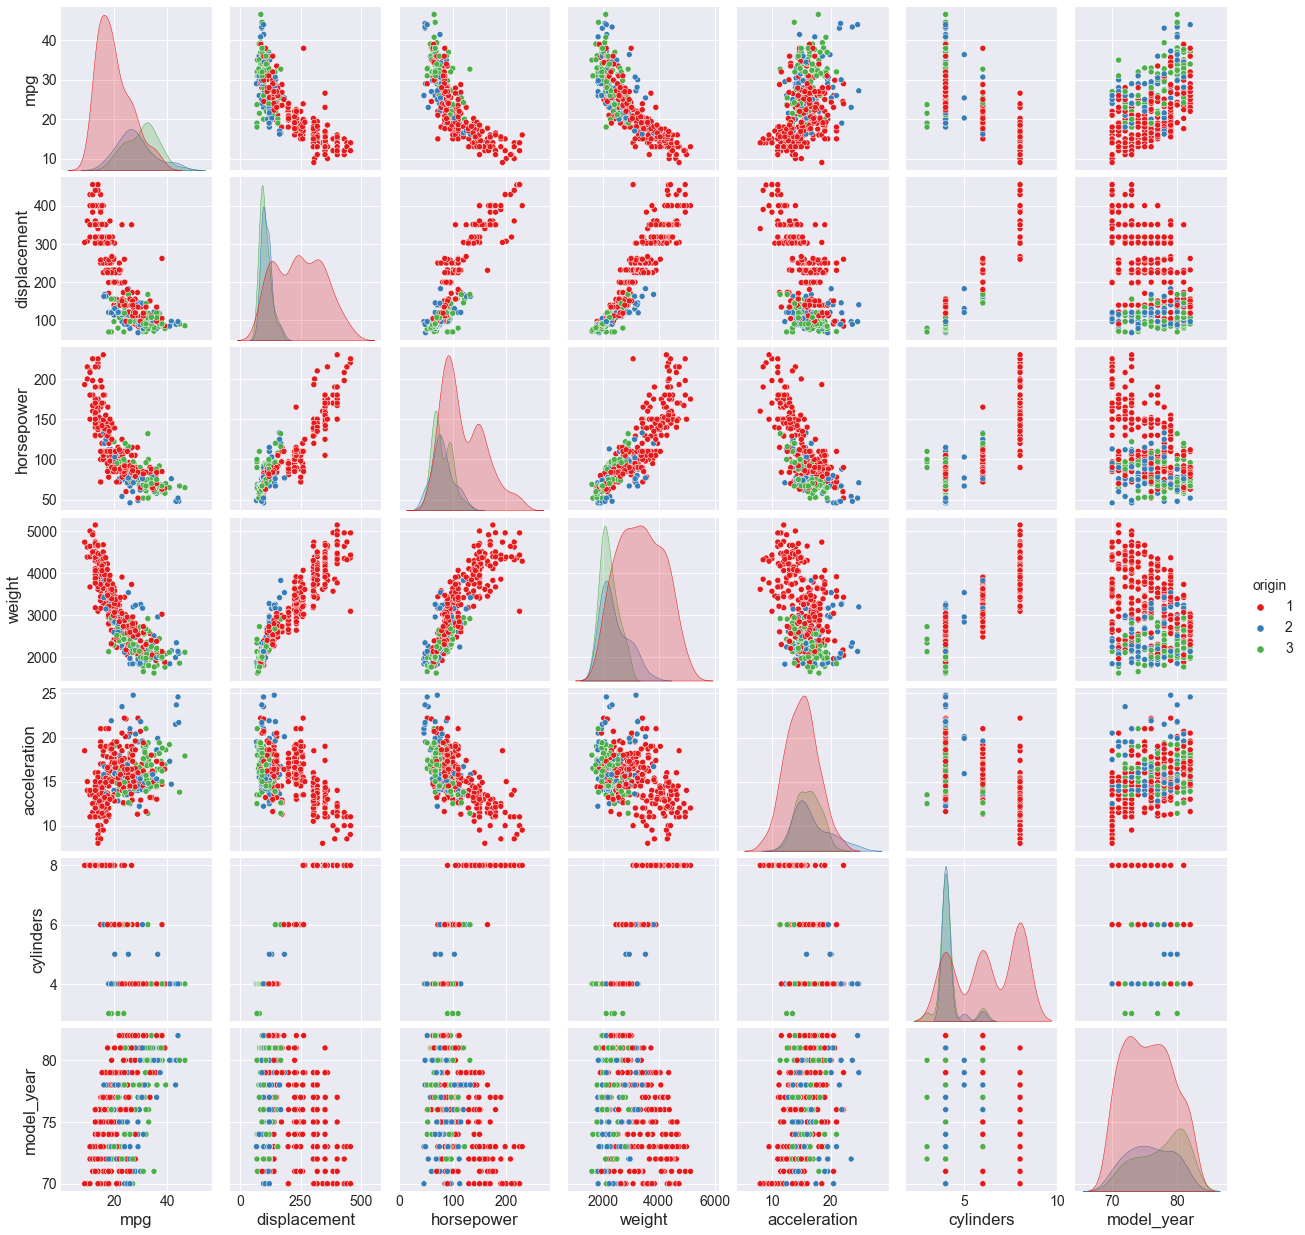

In [18]:
_ = plt.figure()
_ = sns.pairplot(df_auto, diag_kind = "kde",hue = "origin",kind = "scatter",palette = "Set1")
_ = plt.show()



<div class="alert alert-block alert-info">
<b>Build Models</b>
</div>

We now build a baseline model followed by setting up a Voting Classifier.

We start by imputing missing value. Data leakage takes place here. Need to fix this going forward...

In [19]:
median = df_auto['horsepower'].median()
df_auto['horsepower'].fillna(median, inplace=True)
print("Number of null values in age column: {}".format(df_auto['horsepower'].isnull().sum()))


Number of null values in age column: 0


In [20]:
X = df_auto.iloc[:, 1:8]
y = df_auto.iloc[:, 0]
X.head()

displacement  horsepower  weight  acceleration  cylinders  model_year  \
0         307.0       130.0    3504          12.0          8          70   
1         350.0       165.0    3693          11.5          8          70   
2         318.0       150.0    3436          11.0          8          70   
3         304.0       150.0    3433          12.0          8          70   
4         302.0       140.0    3449          10.5          8          70   

   origin  
0       1  
1       1  
2       1  
3       1  
4       1

In [21]:
y.head()

0    18.0
1    15.0
2    18.0
3    16.0
4    17.0
Name: mpg, dtype: float64

In [22]:
y = np.ravel(y)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [24]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
reg = MLPRegressor(max_iter=100000, solver="lbfgs", activation="tanh",hidden_layer_sizes=(5), random_state=1)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mean_squared_error(y_pred,y_test)

20.724461329398306

In [26]:
reg_par = [np.e**n for n in np.arange(-3,6,1)]

validation_scores = {}
print(" alpha  |  Sq.Error")
for param in reg_par:
    reg = MLPRegressor(max_iter=100000, solver="lbfgs", activation="tanh", hidden_layer_sizes=(5), alpha=param, random_state=1)
    score = cross_val_score(estimator=reg, X=X_train, y=y_train, cv=2, scoring="neg_mean_squared_error")
    validation_scores[param] = -score.mean()
    print("%0.5f |  %s" % (param, -score.mean()))


 alpha  |  Sq.Error
0.04979 |  12.000223328286589
0.13534 |  11.033966695748095
0.36788 |  11.192558305868198
1.00000 |  10.893368266711434
2.71828 |  9.289050728673033
7.38906 |  8.634788338077392
20.08554 |  8.987535188358203
54.59815 |  10.756743030826057
148.41316 |  23.02760975261459


Text(0, 0.5, 'Mean Sq Error')

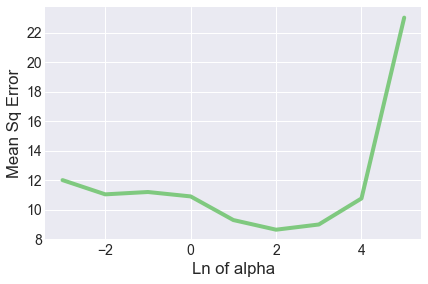

In [27]:
plt.plot([np.log(i) for i in validation_scores.keys()], list(validation_scores.values()))
plt.xlabel("Ln of alpha")
plt.ylabel("Mean Sq Error")

In [28]:
print("The lowest cross validation error is: %s" % (min(validation_scores.values())))
print("This corresponds to regularisation parameter e**-%s" %
      ([np.log(name) for name, score in validation_scores.items()
                         if score==min(validation_scores.values())][0]))

The lowest cross validation error is: 8.634788338077392
This corresponds to regularisation parameter e**-2.0


In [29]:
reg = MLPRegressor(max_iter=100000, solver="lbfgs", activation="tanh", hidden_layer_sizes=(5), alpha=np.e**(2.0), random_state=1)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mean_squared_error(y_pred,y_test)


7.463463196626281

The accuracy score on the optimised model reduced.

In my next submission I will now fit a voting classifier to compare our MLP results with a few other models. Just to
compare to a few other models.

On to the next Notebook!